In [38]:
import torch
import time
import datetime
import seaborn
from sklearn import metrics
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from transformers import CamembertForSequenceClassification, CamembertTokenizer, AutoConfig, AutoModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler

In [39]:
# features = np.array(pickle.load(open("features.p", "rb")), dtype=object)
# labels = np.array(pickle.load(open("labels.p", "rb")), dtype=object)
# docs = np.array(pickle.load(open("docs.p", "rb")), dtype=object)

#docs_train = np.array(pickle.load(open("docs_train.p", "rb")), dtype=object)
#docs_test = np.array(pickle.load(open("docs_test.p", "rb")), dtype=object)
#docs_val = np.array(pickle.load(open("docs_val.p", "rb")), dtype=object)

#features_train = np.array(pickle.load(open("features_train.p", "rb")), dtype=object)
#features_test = np.array(pickle.load(open("features_test.p", "rb")), dtype=object)
#features_validation = np.array(pickle.load(open("features_val.p", "rb")), dtype=object)

#labels_train = np.array(pickle.load(open("labels_train.p", "rb")), dtype=object)
#labels_test = np.array(pickle.load(open("labels_test.p", "rb")), dtype=object)
#labels_validation = np.array(pickle.load(open("labels_val.p", "rb")), dtype=object)





docs = np.array(["ceci est une fake news"]*50).reshape((50, 1))
labels = np.array([2]*10 + [1]*15 + [0]*25).reshape((50, 1))
features = np.ones((50, 4)).astype("float")

dataset = np.hstack((labels, docs, features))

np.random.shuffle(dataset)

print(f'Dataset: {dataset.shape}')

labels = np.array(dataset[:, 0], dtype=int) # - 1
docs = dataset[:, 1]
features = np.array(dataset[:, 2:], dtype = np.float32)
print(features.dtype)


num_extra_dims = np.shape(features)[1]
num_labels = len(set(labels))

Dataset: (50, 6)
float32


In [40]:
print(Counter(labels))

Counter({0: 25, 1: 15, 2: 10})


In [41]:
class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
class_weights=torch.tensor(class_weights,dtype=torch.float)
 
print(class_weights) #([1.0000, 1.0000, 4.0000, 1.0000, 0.5714])

tensor([0.6667, 1.1111, 1.6667])


/Users/paulmeddeb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 0 0 0 1 0 1 0 2 2 2 0 0 0 0 1 0 1 2 0 0 2 1 2 0 0 0 1 1 1 2 1 0 0 0
 0 2 1 0 2 0 1 1 0 2 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [42]:
TOKENIZER = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

In [43]:
def preprocess_spacy(docs, pos=["PUNCT", "ADV", "ADJ", "VERB", "NOUN"]):
    texts = [" ".join([token.text for token in doc if not token.is_stop and token.pos_ in pos]) for doc in docs]

    return texts

def preprocess(raw_articles, features = None, labels=None):
    """
        Create pytorch dataloader from raw data
    """

    # https://huggingface.co/docs/transformers/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.batch_encode_plus.truncation

    encoded_batch = TOKENIZER.batch_encode_plus(raw_articles,
                                                add_special_tokens=False,
                                                padding = True,
                                                truncation = True,
                                                max_length = 512,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
        

    if features is not None:
        features = torch.tensor(features)
        if labels is not None:
            labels = torch.tensor(labels)
            return encoded_batch['input_ids'], encoded_batch['attention_mask'], features, labels
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], features
    
    else :
        if labels is not None:
            labels = torch.tensor(labels)
            return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
        return encoded_batch['input_ids'], encoded_batch['attention_mask']
        

articles = docs #to comment !
#articles_train, articles_test, articles_validation = preprocess_spacy(docs_train), preprocess_spacy(docs_test), preprocess_spacy(docs_val)
#print(TOKENIZER.convert_ids_to_tokens(preprocess(articles, features = features, labels=labels)[0][0]))

In [44]:
# Split train-validation to-comment !!
split_border = int(len(labels)*0.8)
articles_train, articles_validation = articles[:split_border], articles[split_border:]
features_train, features_validation = features[:split_border], features[split_border:]
labels_train, labels_validation = labels[:split_border], labels[split_border:]

In [45]:
input_ids, attention_mask, features_train, labels_train = preprocess(articles_train, features_train, labels_train)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    input_ids,
    attention_mask,
    features_train,
    labels_train)
    

input_ids, attention_mask, features_validation, labels_validation = preprocess(articles_validation, features_validation, labels_validation)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    input_ids,
    attention_mask,
    features_validation,
    labels_validation)

In [46]:
batch_size = 32

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [47]:
class CustomModel(torch.nn.Module):
    """
    This takes a transformer backbone and puts a slightly-modified classification head on top.
    
    """

    def __init__(self, model_name, num_extra_dims, num_labels):
        # num_extra_dims corresponds to the number of extra dimensions of numerical/categorical data

        super().__init__()

        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name, config=self.config)
        num_hidden_size = self.transformer.config.hidden_size # May be different depending on which model you use. Common sizes are 768 and 1024. Look in the config.json file 
        self.classifier = torch.nn.Linear(num_hidden_size+num_extra_dims, num_labels)


    def forward(self, input_ids, extra_data, attention_mask=None):
        """
        extra_data should be of shape [batch_size, dim] 
        where dim is the number of additional numerical/categorical dimensions
        """

        hidden_states = self.transformer(input_ids=input_ids, attention_mask=attention_mask) # [batch size, sequence length, hidden size]

        cls_embeds = hidden_states[0][:, 0, :] # [batch size, hidden size]

        concat = torch.cat((cls_embeds, extra_data), dim=-1) # [batch size, hidden size+num extra dims]

        output = self.classifier(concat) # [batch size, num labels]

        return output


In [48]:
model_name = "camembert-base"
model = CustomModel(model_name, num_extra_dims=num_extra_dims, num_labels=num_labels)

In [49]:
def predict(articles, features, model=model):
    with torch.no_grad():
        model.eval()
        input_ids, attention_mask, extra_data = preprocess(articles, features)
        output = model(input_ids, extra_data, attention_mask=attention_mask)
        return torch.argmax(output, dim=1)
print(predict(articles_train[:10], features_train[:10]))

<ipython-input-43-9ba8d58322e6>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features)


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [50]:
def evaluate(articles, features, labels, metric='report'):
    predictions = predict(articles, features)
    if metric == 'report':
        return metrics.classification_report(labels, predictions, zero_division=0)
    elif metric == 'matrix':
        return metrics.confusion_matrix(labels, predictions)

In [51]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [52]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )



In [53]:
SAVE_PATH = "customed_camembert_model.model"

# Training loop
training_stats = []
                                                                                
# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 12

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

# Training
for epoch in range(0, epochs):
    
    print("")
    print(f'########## Epoch {epoch} / {epochs} ##########')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    print('test time')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        print(f'step : {step}')

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0
            
            # Report progress
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: skills 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        feature = batch[2].to(device)
        label = batch[3].to(device)

        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        # the loss (because we provided skills) and the "logits"--the model
        # outputs prior to activation
        logits = model(input_id,
                       feature, 
                       attention_mask=attention_mask)
        
        loss = criterion(logits, label)
        print(loss)


        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 'loss' is a Tensor containing a
        # single value; the '.item()' function just returns the Python value 
        # from the tensor
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)   

    if epoch > 0:
        if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
            # i.e. If there is not improvement
            consecutive_epochs_with_no_improve += 1
        else:
            # If there is improvement
            consecutive_epochs_with_no_improve = 0
            print("Model saved!")
            torch.save(model.state_dict(), SAVE_PATH)
    
    # Measure how long this epoch took
    training_time = time.time() - t0

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )
    if consecutive_epochs_with_no_improve == 2:
        print("Stop training : The loss has not changed since 2 epochs!")
        break
        
torch.save(model.state_dict(), SAVE_PATH)


########## Epoch 0 / 12 ##########
Training...
test time
step : 0
tensor(1.1022, grad_fn=<NllLossBackward0>)


/Users/paulmeddeb/opt/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


step : 1
tensor(1.1134, grad_fn=<NllLossBackward0>)

  Average training loss: 1.11
  Training epoch took: 3.3993921279907227

########## Epoch 1 / 12 ##########
Training...
test time
step : 0
tensor(1.1059, grad_fn=<NllLossBackward0>)
step : 1
tensor(1.1020, grad_fn=<NllLossBackward0>)
Model saved!

  Average training loss: 1.10
  Training epoch took: 2.8495922088623047

########## Epoch 2 / 12 ##########
Training...
test time
step : 0
tensor(1.1078, grad_fn=<NllLossBackward0>)
step : 1
tensor(1.0826, grad_fn=<NllLossBackward0>)
Model saved!

  Average training loss: 1.10
  Training epoch took: 2.869687795639038

########## Epoch 3 / 12 ##########
Training...
test time
step : 0
tensor(1.0927, grad_fn=<NllLossBackward0>)
step : 1
tensor(1.1077, grad_fn=<NllLossBackward0>)

  Average training loss: 1.10
  Training epoch took: 2.364192008972168

########## Epoch 4 / 12 ##########
Training...
test time
step : 0
tensor(1.1064, grad_fn=<NllLossBackward0>)
step : 1
tensor(1.0893, grad_fn=<Nll

<ipython-input-43-9ba8d58322e6>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features)
<ipython-input-43-9ba8d58322e6>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         2
           2       0.20      1.00      0.33         2

    accuracy                           0.20        10
   macro avg       0.07      0.33      0.11        10
weighted avg       0.04      0.20      0.07        10

[[0 0 6]
 [0 0 2]
 [0 0 2]]


<AxesSubplot:>

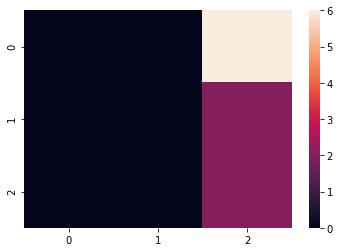

In [55]:
confusion_matrix = evaluate(articles_validation, features_validation, labels_validation, 'matrix')
report = evaluate(articles_validation, features_validation, labels_validation, 'report')
print(report)
print(confusion_matrix)
seaborn.heatmap(confusion_matrix)